# HMM: Performance evaluation

Jacqueline R. M. A. Maasch | March 2022

## Preamble

In [1]:
# Importations.
import moses
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wasserstein_distance
from moses.metrics import weight, logP, SA, QED
from moses.metrics.utils import get_mol, mapper
from moses import get_dataset
from collections import OrderedDict
from tdc.chem_utils import MolFilter
import warnings
from tdc import Oracle

import tdc
from tdc import Evaluator
from tdc.single_pred import HTS
from importlib.metadata import version

In [2]:
%%capture
# Installs.
#!python3.8 -m pip install fcd_torch
#!python3.8 -m pip install rxn4chemistry

## Define functions

In [66]:
def compute_tdc_metrics(generated, training):
    
    metrics_dict = dict()
    
    kl = Evaluator(name = "KL_Divergence")
    metrics_dict["KL divergence"] = kl(generated, training)

    uniqueness = Evaluator(name = "Uniqueness")
    metrics_dict["Uniqueness"] = uniqueness(generated)

    validity = Evaluator(name = "Validity")
    metrics_dict["Validity"] = validity(generated)

    novelty = Evaluator(name = "Novelty")
    metrics_dict["Novelty"] = novelty(generated, training)

    #fcd = Evaluator(name = "FCD_Distance")
    #metrics_dict["FCD distance"] = fcd(generated, training)

    diversity = Evaluator(name = "Diversity")
    metrics_dict["Diversity"] = diversity(generated)

    return metrics_dict


def remove_ungrammatical(generated):
    keep = []
    for molecule in generated:
        opening_parens = molecule.count("(")
        closing_parens = molecule.count(")")
        if opening_parens == closing_parens:
            keep.append(molecule)
    return keep


def plot_distribution_basic(df):
    sns.displot(data = df, 
                x = "Data", 
                hue = "Distribution", 
                col = "Metric",
                kind = "kde", 
                #log_scale = (2, 2),
                common_norm = True,
                fill = True,
                height = 5)
    plt.show()
    
    
def plot_distribution(df, save_path="./plt.pdf", save=False):
    g = sns.FacetGrid(df.reset_index(), 
                      col="Metric",
                      hue="Distribution", 
                      sharex=False, 
                      sharey=False)
    g.map_dataframe(sns.kdeplot, 
                    "Data", 
                    fill=True, 
                    common_norm = True).add_legend()
    if save:
        plt.savefig(save_path)
    else:
        plt.show()

## Read data

### Generated molecules

In [4]:
# Read in generated molecules.
df = pd.read_csv("de_novo_data/hmm_de_novo_2k.csv")
print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMILES  2000 non-null   object
 1   Active  2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None


SMILES  Active
0  CC(=O)c1ncc([C@H]1CO)C(=O)C(C)S[C@H](CCC1=CC(=...       1
1                                          CC(C)C)n1       1
2  COC(=O)(=O)CCl)N1CCN(Cc3nc(O)c3cn1nn[nH]2Cn2cc...       1
3                          CC1CC2)C[C@]2(C2CCCCC3)c1       1
4        N[C@H]1[C@]43C)[C@@H]3[C@H]2[C@@H]1CCC2(CC1       1

In [5]:
# Disaggregate molecules sampled from active model vs inactive model.
df_active = df[df["Active"] == 1]
df_inactive = df[df["Active"] == 0]

print(df_active.info())
display(df_active.head())

print(df_inactive.info())
display(df_inactive.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMILES  1000 non-null   object
 1   Active  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.4+ KB
None


SMILES  Active
0  CC(=O)c1ncc([C@H]1CO)C(=O)C(C)S[C@H](CCC1=CC(=...       1
1                                          CC(C)C)n1       1
2  COC(=O)(=O)CCl)N1CCN(Cc3nc(O)c3cn1nn[nH]2Cn2cc...       1
3                          CC1CC2)C[C@]2(C2CCCCC3)c1       1
4        N[C@H]1[C@]43C)[C@@H]3[C@H]2[C@@H]1CCC2(CC1       1

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1000 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMILES  1000 non-null   object
 1   Active  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.4+ KB
None


SMILES  Active
1000  Cc1nnc(N(C)C(=O)c2ccc(OC)c(C(=O)c1ccc(C(N)(CC(...       0
1001                          CCCOc1cccns1-c1nc3ccccc21       0
1002                                     CC(=O)[O-])CC1       0
1003   CN(C)C)=C(C/C=C(CNC2)cncn2)n2C(=O)O)CC1=C[C@]12O       0
1004  O=C(\C(=O)c4ccc(C(=O)[C@@H]1[C@H](CC[C@H]2[C@H...       0

### Training data from TDC

In [6]:
# Default random state seed for TDC.
# Read about split methods here: https://tdcommons.ai/functions/data_split/
# Consider scaffold split over random split in the future.
random_seed = 42

# SARS-CoV-2 In Vitro, Touret et al.
data_touret = HTS(name = "SARSCoV2_Vitro_Touret")
split_touret = data_touret.get_split(method = "random", 
                                     seed = random_seed, 
                                     frac = [0.7, 0.1, 0.2])

# SARS-CoV-2 3CL Protease, Diamond.
data_diamond = HTS(name = "SARSCoV2_3CLPro_Diamond")
split_diamond = data_diamond.get_split(method = "random", 
                                       seed = random_seed, 
                                       frac = [0.7, 0.1, 0.2])

# Explore data.
print("dataset datatype:", type(data_touret))
print("data split datatype:", type(split_touret), "\n")
display(data_touret)
print()
display(split_touret)

# Extract training / validation / testing sets.
train_touret = split_touret.get("train")
val_touret = split_touret.get("valid")
test_touret = split_touret.get("test")

train_diamond = split_diamond.get("train")
val_diamond = split_diamond.get("valid")
test_diamond = split_diamond.get("test")

Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!


dataset datatype: <class 'tdc.single_pred.hts.HTS'>
data split datatype: <class 'dict'> 



{'train':       Drug_ID                                               Drug  Y
 0           0                       CCOc1ccc2nc(S(N)(=O)=O)sc2c1  1
 1           1  C[C@]12C/C(=C/O)C(=O)C[C@@H]1CC[C@@H]1[C@@H]2C...  1
 2           2               Cc1nccn1CC1CCc2c(c3ccccc3n2C)C1=O.Cl  1
 3           3  CC(=O)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C@@H](O)CC[C...  1
 4           4  C=C1CC[C@@]2(O)[C@H]3Cc4ccc(O)c5c4[C@@]2(CCN3C...  1
 ...       ...                                                ... ..
 1034     1477                        O=C(CCCCCCC(=O)Nc1ccccc1)NO  0
 1035     1478        COc1ccccc1OCCNCC(O)COc1cccc2[nH]c3ccccc3c12  0
 1036     1481  Clc1ccc(C(Cn2ccnc2)OCc2csc3c(Cl)cccc23)c(Cl)c1...  0
 1037     1482  CCSc1ccc2c(c1)N(CCCN1CCN(C)CC1)c1ccccc1S2.O=C(...  0
 1038     1483  C=Cc1c(C)c2cc3nc(cc4[nH]c(cc5nc(cc1[nH]2)C(C)=...  0
 
 [1039 rows x 3 columns],
 'valid':      Drug_ID                                               Drug  Y
 0        581              CC(=O)OCC(CCn1cnc2cnc(N)nc21)CO

In [7]:
# Explore data splits.
print("\n~~~~~ TOURET: SARS-CoV-2 In Vitro, Touret et al. ~~~~~\n")
print("\n--- TRAINING SPLIT ---\n")
print(train_touret.Y.value_counts())
print(train_touret.Y.value_counts(normalize = True), "\n")
print(train_touret.info())
display(train_touret.head())
print("\n--- VALIDATION SPLIT ---\n")
print(val_touret.Y.value_counts())
print(val_touret.Y.value_counts(normalize = True), "\n")
print(val_touret.info())
display(val_touret.head())
print("\n--- TEST SPLIT ---\n")
print(test_touret.Y.value_counts())
print(test_touret.Y.value_counts(normalize = True), "\n")
print(test_touret.info())
display(test_touret.head())

# Explore data splits.
print("\n~~~~~ DIAMOND: SARS-CoV-2 3CL Protease, Diamond et al. ~~~~~\n")
print("\n--- TRAINING SPLIT ---\n")
print(train_diamond.Y.value_counts())
print(train_diamond.Y.value_counts(normalize = True), "\n")
print(train_diamond.info())
display(train_diamond.head())
print("\n--- VALIDATION SPLIT ---\n")
print(val_diamond.Y.value_counts())
print(val_diamond.Y.value_counts(normalize = True), "\n")
print(val_diamond.info())
display(val_diamond.head())
print("\n--- TEST SPLIT ---\n")
print(test_diamond.Y.value_counts())
print(test_diamond.Y.value_counts(normalize = True), "\n")
print(test_diamond.info())
display(test_diamond.head())


~~~~~ TOURET: SARS-CoV-2 In Vitro, Touret et al. ~~~~~


--- TRAINING SPLIT ---

0    977
1     62
Name: Y, dtype: int64
0    0.940327
1    0.059673
Name: Y, dtype: float64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1039 entries, 0 to 1038
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Drug_ID  1039 non-null   int64 
 1   Drug     1039 non-null   object
 2   Y        1039 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 24.5+ KB
None


Drug_ID                                               Drug  Y
0        0                       CCOc1ccc2nc(S(N)(=O)=O)sc2c1  1
1        1  C[C@]12C/C(=C/O)C(=O)C[C@@H]1CC[C@@H]1[C@@H]2C...  1
2        2               Cc1nccn1CC1CCc2c(c3ccccc3n2C)C1=O.Cl  1
3        3  CC(=O)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C@@H](O)CC[C...  1
4        4  C=C1CC[C@@]2(O)[C@H]3Cc4ccc(O)c5c4[C@@]2(CCN3C...  1


--- VALIDATION SPLIT ---

0    141
1      7
Name: Y, dtype: int64
0    0.952703
1    0.047297
Name: Y, dtype: float64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Drug_ID  148 non-null    int64 
 1   Drug     148 non-null    object
 2   Y        148 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ KB
None


Drug_ID                                               Drug  Y
0      581              CC(=O)OCC(CCn1cnc2cnc(N)nc21)COC(C)=O  0
1      375  CC(=O)S[C@@H]1CC2=CC(=O)CC[C@]2(C)[C@H]2CC[C@@...  0
2      703                   Nc1nc2c(ncn2CCC(CO)CO)c(=O)[nH]1  0
3     1039                       NC(=O)N1c2ccccc2C=Cc2ccccc21  0
4      610              O=C(O)CCc1nc(-c2ccccc2)c(-c2ccccc2)o1  0


--- TEST SPLIT ---

0    278
1     19
Name: Y, dtype: int64
0    0.936027
1    0.063973
Name: Y, dtype: float64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Drug_ID  297 non-null    int64 
 1   Drug     297 non-null    object
 2   Y        297 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.1+ KB
None


Drug_ID                                               Drug  Y
0      123               CCCCOc1cc(C(=O)NCCN(CC)CC)c2ccccc2n1  0
1      432  C[C@H](O)[C@H](O)[C@H]1CNc2nc(N)[nH]c(=O)c2N1....  0
2     1033         CS(=O)(=O)Nc1ccc([N+](=O)[O-])cc1Oc1ccccc1  0
3      529  CN1CCCCC1CCN1c2ccccc2Sc2ccc(S(C)=O)cc21.O=S(=O...  0
4     1417                 CNCCCC12CCC(c3ccccc31)c1ccccc12.Cl  0


~~~~~ DIAMOND: SARS-CoV-2 3CL Protease, Diamond et al. ~~~~~


--- TRAINING SPLIT ---

0    568
1     48
Name: Y, dtype: int64
0    0.922078
1    0.077922
Name: Y, dtype: float64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Drug_ID  616 non-null    int64 
 1   Drug     616 non-null    object
 2   Y        616 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 14.6+ KB
None


Drug_ID                                     Drug  Y
0        1             CC(=O)NCCc1c[nH]c2ccc(F)cc12  1
1        2             NC(=O)[C@H]1CCC[C@H]1c1ccsc1  1
2        3              CN1CCCc2ccc(S(N)(=O)=O)cc21  1
3        4               CC(=O)Nc1ccc(Oc2ncccn2)cc1  1
4        6  O=C(CCl)N1CCN(S(=O)(=O)c2ccc(Cl)cc2)CC1  1


--- VALIDATION SPLIT ---

0    78
1    10
Name: Y, dtype: int64
0    0.886364
1    0.113636
Name: Y, dtype: float64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Drug_ID  88 non-null     int64 
 1   Drug     88 non-null     object
 2   Y        88 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 2.2+ KB
None


Drug_ID                              Drug  Y
0      498        CC(=O)NCC1(c2ccccc2)CCOCC1  0
1      524       Nc1cc(C(F)(F)F)ccc1N1CCCCC1  0
2      410             Cn1cc(Oc2ncncc2Cl)cn1  0
3      233                  CC1(C(N)=O)CCCN1  0
4      229  O=C(CCl)N1CCN(Cc2c(F)cccc2Cl)CC1  0


--- TEST SPLIT ---

0    156
1     20
Name: Y, dtype: int64
0    0.886364
1    0.113636
Name: Y, dtype: float64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Drug_ID  176 non-null    int64 
 1   Drug     176 non-null    object
 2   Y        176 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 4.2+ KB
None


Drug_ID                               Drug  Y
0      331       CCOc1ccc(NC(=O)NC(C)(C)C)cc1  0
1      247             C[C@H]1CN(C)CC[C@H]1CO  0
2      790          CC(C)C(=O)N1CCN(C(C)C)CC1  0
3      316  Cc1ccccc1C(=O)NC1CCN(C(=O)CCl)CC1  0
4      215               C[C@H]1NCCC[C@H]1C#N  0

In [8]:
# Agreggate all actives.
touret_pos = pd.concat([train_touret[train_touret.Y == 1],
                        val_touret[val_touret.Y == 1],
                        test_touret[test_touret.Y == 1]])

diamond_pos = pd.concat([train_diamond[train_diamond.Y == 1],
                         val_diamond[val_diamond.Y == 1],
                         test_diamond[test_diamond.Y == 1]])
df_train_active = pd.concat([touret_pos, diamond_pos])

print(df_train_active.Y.value_counts())
print(df_train_active.info())
display(df_train_active.head())

# Agreggate all inactives.
touret_neg = pd.concat([train_touret[train_touret.Y == 0],
                        val_touret[val_touret.Y == 0],
                        test_touret[test_touret.Y == 0]])

diamond_neg = pd.concat([train_diamond[train_diamond.Y == 0],
                         val_diamond[val_diamond.Y == 0],
                         test_diamond[test_diamond.Y == 0]])
df_train_inactive = pd.concat([touret_neg, diamond_neg])

print(df_train_inactive.Y.value_counts())
print(df_train_inactive.info())
display(df_train_inactive.head())

1    166
Name: Y, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 166 entries, 0 to 169
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Drug_ID  166 non-null    int64 
 1   Drug     166 non-null    object
 2   Y        166 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 5.2+ KB
None


Drug_ID                                               Drug  Y
0        0                       CCOc1ccc2nc(S(N)(=O)=O)sc2c1  1
1        1  C[C@]12C/C(=C/O)C(=O)C[C@@H]1CC[C@@H]1[C@@H]2C...  1
2        2               Cc1nccn1CC1CCc2c(c3ccccc3n2C)C1=O.Cl  1
3        3  CC(=O)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C@@H](O)CC[C...  1
4        4  C=C1CC[C@@]2(O)[C@H]3Cc4ccc(O)c5c4[C@@]2(CCN3C...  1

0    2198
Name: Y, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2198 entries, 62 to 175
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Drug_ID  2198 non-null   int64 
 1   Drug     2198 non-null   object
 2   Y        2198 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 68.7+ KB
None


Drug_ID                                             Drug  Y
62       88  CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)C(C)(C)CCC1  0
63       89  CCC(COC(=O)c1cc(OC)c(OC)c(OC)c1)(c1ccccc1)N(C)C  0
64       90           Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1  0
65       91        CC(C)=CCC1C(=O)N(c2ccccc2)N(c2ccccc2)C1=O  0
66       92         CCN1CCCC(OC(=O)C(c2ccccc2)c2ccccc2)C1.Cl  0

In [9]:
# Extract SMILES for training and generated data.
actives_train = df_train_active["Drug"]
inactives_train = df_train_inactive["Drug"]
actives_gen = df_active["SMILES"]
inactives_gen = df_inactive["SMILES"]

print("Total training actives:", len(actives_train))
print("Total training inactives:", len(inactives_train))
print("Total generated actives:", len(actives_gen))
print("Total generated inactives:", len(inactives_gen), "\n")
print(actives_train[:10])
print(actives_gen[:10])

Total training actives: 166
Total training inactives: 2198
Total generated actives: 1000
Total generated inactives: 1000 

0                         CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1    C[C@]12C/C(=C/O)C(=O)C[C@@H]1CC[C@@H]1[C@@H]2C...
2                 Cc1nccn1CC1CCc2c(c3ccccc3n2C)C1=O.Cl
3    CC(=O)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C@@H](O)CC[C...
4    C=C1CC[C@@]2(O)[C@H]3Cc4ccc(O)c5c4[C@@]2(CCN3C...
5                        C=CCOc1ccccc1OCC(O)CNC(C)C.Cl
6                       CC(C)=C/C(C)=N/Nc1nncc2ccccc12
7    CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...
8      CC1=C(/C=C/C(C)=C/C=C/C(C)=C\C(=O)O)C(C)(C)CCC1
9    COC(c1ccccc1)(c1ccccc1)[C@H](Oc1nc(C)cc(C)n1)C...
Name: Drug, dtype: object
0    CC(=O)c1ncc([C@H]1CO)C(=O)C(C)S[C@H](CCC1=CC(=...
1                                            CC(C)C)n1
2    COC(=O)(=O)CCl)N1CCN(Cc3nc(O)c3cn1nn[nH]2Cn2cc...
3                            CC1CC2)C[C@]2(C2CCCCC3)c1
4          N[C@H]1[C@]43C)[C@@H]3[C@H]2[C@@H]1CCC2(CC1
5    O=C(NC[O@@H]3C(=O)c3c

## Filter molecules

>Function Description: This function identifies and removes typical not drug-like molecules (false positives) using various types of filters curated by Patrick Walters. This is a wrapper around his rd_filters GitHub package. Also checkout his blog post for more info. You can specify the rules for the filters. For example, specify what kinds of structure alerts to use and also the range for some properties. (https://tdcommons.ai/functions/data_process/#molecule-filters)[https://tdcommons.ai/functions/data_process/#molecule-filters]

In [10]:
# Remove molecules without matching parantheses.
# Note that this step is not enough to demonstrate valid SMILES syntax.
actives_grammatical = remove_ungrammatical(actives_gen)
inactives_grammatical = remove_ungrammatical(inactives_gen)

print("Total grammatical actives:", len(actives_grammatical))
print("Total ungrammatical actives:", len(actives_gen) - len(actives_grammatical))
print("Percent ungrammatical actives:", len(actives_grammatical) / len(actives_gen))
print("-------------------------------------------")
print("Total grammatical inactives:", len(inactives_grammatical))
print("Total ungrammatical inactives:", len(inactives_gen) - len(inactives_grammatical))
print("Percent ungrammatical inactives:", len(inactives_grammatical) / len(inactives_gen))

Total grammatical actives: 344
Total ungrammatical actives: 656
Percent ungrammatical actives: 0.344
-------------------------------------------
Total grammatical inactives: 372
Total ungrammatical inactives: 628
Percent ungrammatical inactives: 0.372


In [11]:
MolFilter?

Init signature:
MolFilter(
    filters='all',
    property_filters_flag=True,
    HBA=[0, 10],
    HBD=[0, 5],
    LogP=[-5, 5],
    MW=[0, 500],
    Rot=[0, 10],
    TPSA=[0, 200],
)
Docstring:     
Molecule Filter: filter Molecule based on user-specified condition 

Args:
  filters: 
  property_filters_flag: bool, 
  HBA: [lower_bound, upper_bound]
  HBD: [lower_bound, upper_bound]
  LogP: [lower_bound, upper_bound]
  MW: [lower_bound, upper_bound],   Molecule weight
  Rot: [lower_bound, upper_bound]
  TPSA: [lower_bound, upper_bound]

Returns:
  list of SMILES strings that pass the filter. 
File:           /opt/anaconda3/lib/python3.8/site-packages/tdc/chem_utils/oracle/filter.py
Type:           type
Subclasses:     


In [12]:
# Init TDC filter.
filters = MolFilter()

MolFilter is using the following filters:
HBA: [0, 10]
HBD: [0, 5]
LogP: [-5, 5]
MW: [0, 500]
Rot: [0, 10]
Rule_BMS: True
Rule_Dundee: True
Rule_Glaxo: True
Rule_Inpharmatica: True
Rule_LINT: True
Rule_MLSMR: True
Rule_PAINS: True
Rule_SureChEMBL: True
TPSA: [0, 200]


### Actives

In [13]:
# Filter active de novo molecules.
actives_gen_filtered = filters(actives_grammatical)

[15:18:37] SMILES Parse Error: extra close parentheses while parsing: N[C@H]1[C@]43C)[C@@H]3[C@H]2[C@@H]1CCC2(CC1
[15:18:37] SMILES Parse Error: Failed parsing SMILES 'N[C@H]1[C@]43C)[C@@H]3[C@H]2[C@@H]1CCC2(CC1' for input: 'N[C@H]1[C@]43C)[C@@H]3[C@H]2[C@@H]1CCC2(CC1'
[15:18:37] SMILES Parse Error: unclosed ring for input: 'Cc1n[nH]2[C@@H]1'
[15:18:37] SMILES Parse Error: unclosed ring for input: 'N[C@@H]3[C@H](O)C(=O)N21'
[15:18:37] SMILES Parse Error: unclosed ring for input: 'CC(C)=C(CCl)N1CCN(C)C'
[15:18:37] Explicit valence for atom # 3 Cl, 2, is greater than permitted
[15:18:37] SMILES Parse Error: unclosed ring for input: 'CO[C@@H](C)[C@H]c2c(c1OC.O=CS(=O)C=C1CC[C@H](O)(=O)=O\[C@@H]1CC[C@@]12CC[C@@H](N)=S)c1'
[15:18:37] SMILES Parse Error: unclosed ring for input: 'CC[C@@H]1CC[C@@]2(C)O'
[15:18:37] SMILES Parse Error: syntax error while parsing: O=C(CCr)CCl
[15:18:37] SMILES Parse Error: Failed parsing SMILES 'O=C(CCr)CCl' for input: 'O=C(CCr)CCl'
[15:18:37] Can't kekulize mol.

In [14]:
# View filtered molecules.
print("Total active de novos post-filtering:", len(actives_gen_filtered)) 
print("-------------------------------------------")
print(actives_gen_filtered)

Total active de novos post-filtering: 25
-------------------------------------------
['Cc1ccccc1' 'CC(=O)O' 'COc1ccccc1' 'Oc1cccnc1' 'CC(=O)O' 'Cc1ccccc1'
 'Cc1ccccc1' 'CC(=O)O' 'Cc1ccccc1' 'Cc1ccccc1' 'Cl' 'CCCc1ccccn1'
 'Cc1ccccc1' 'CC(=O)O' 'CN(C)C' 'CC(C)(C)O' 'CC(=O)O' 'Cc1ccccc1'
 'CC(N)=O' 'c1ccccc1' 'Oc1ccccn1' 'CCCc1ccc(Cl)cc1' 'CC(=O)O'
 'CNc1ccc(OC)nc1OC' 'CC(=O)O']


### Inactives

In [15]:
# Filter inactive de novo molecules.
inactives_gen_filtered = filters(inactives_grammatical)

[15:18:40] SMILES Parse Error: unclosed ring for input: 'CCCOc1cccns1-c1nc3ccccc21'
[15:18:40] SMILES Parse Error: unclosed ring for input: 'O=C/C(=S(=O)COc1nc(O)ccc2cc1)C(=O)O'
[15:18:40] SMILES Parse Error: unclosed ring for input: 'CN1CCCC(OC.NC(=O)[O-].CNC1C(=O)N1S(F)=O)C(=O)=O'
[15:18:40] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 7
[15:18:40] SMILES Parse Error: unclosed ring for input: 'CCC/N=C(O)c2ccc(N)c1C'
[15:18:40] SMILES Parse Error: unclosed ring for input: 'COCC(O)/C=C([nH]7[C@H](O)[C@@H]1C(=O)[O-])c1'
[15:18:40] SMILES Parse Error: extra close parentheses while parsing: COc1ccccc2)[C@H]1N2S(=O)OCC(O)c1cccc(S(=O)c1ccccc1
[15:18:40] SMILES Parse Error: Failed parsing SMILES 'COc1ccccc2)[C@H]1N2S(=O)OCC(O)c1cccc(S(=O)c1ccccc1' for input: 'COc1ccccc2)[C@H]1N2S(=O)OCC(O)c1cccc(S(=O)c1ccccc1'
[15:18:40] SMILES Parse Error: unclosed ring for input: 'CC(=O)(=O)c3ccccc2cc1Cl'
[15:18:40] SMILES Parse Error: extra close parentheses while parsing: OC=O)[nH](C(=O)N3CCCC2.O.[Na+

In [16]:
# View filtered molecules.
print("Total inactive de novos post-filtering:", len(inactives_gen_filtered)) 
print("-------------------------------------------")
print(inactives_gen_filtered)

Total inactive de novos post-filtering: 58
-------------------------------------------
['CN(CC)C' 'CN1CCOCC1' 'c1ccccn1' 'Cc1cccs1' 'COCC(=O)O' 'Cc1ccccc1'
 'CN(CC)C' 'CC(C)(C)[C@H]1CN=C1CC[C@H]1C[C@H]1C' 'Cc1ccccc1' 'Cl' 'O.Cl'
 'CN1CCN(c3ccccc3)CC1.Cl' 'O.Cl' 'COc1ccccc1' 'COCc1ccccc1.Cl' 'Cc1ccccc1'
 'CC(=O)O' 'CSc1nnnnn1' 'OCCOc1ccc(O)cc1' 'O=C(O)c1ccccn1' 'CN1CCCCCC1'
 'COc1ccc(Cl)cc1OC' 'Cn1cc(F)cc1' 'CCOc1ccccn1' 'Cl.Cl' 'Cl'
 'CN(CC)CC.[Na+]' 'C[C@H](C)O' 'CC1COCC1' 'COc1ccc(OC)cc1' 'Cc1ccccc1'
 'CC(=O)O' 'CNC(C)(C)c1ccccc1Cl' 'Cl' 'Cc1ccccc1' 'CC(=O)Nc1cccnc1' 'Cl'
 'Cl' 'Cc1ccccc1' 'COc1ccccc1' 'CCOc1ccccc1' 'CC(=O)O' 'Cc1ccccc1'
 'CCCOc1ccccc1' 'Cl' 'C[N+]' 'Cc1ccccc1' 'Cc1ccncc1' 'Cl.O' 'CC(=O)O'
 'Cc1ccccc1N1CCNCC1' 'Cl' 'C[N+]' 'NCCc1ccc(CCc2ccccc2)CC1.Cl'
 'OCCOc1ccccc1' 'Oc1cc(O)ccc1C' 'Cn1cc(Cl)nc1' 'CCCN(C)C']


### Training data

In [17]:
# Filter training data.
# Filter active de novo molecules.
actives_train_filtered = filters(list(actives_train))
inactives_train_filtered = filters(list(inactives_train))

print("Total valid training actives:", len(actives_train_filtered))
print("Total invalid training actives:", len(actives_train) - len(actives_train_filtered))
print("Percent invalid training actives:", len(actives_train_filtered) / len(actives_train))
print("-------------------------------------------")
print("Total valid training inactives:", len(inactives_train_filtered))
print("Total invalid training inactives:", len(inactives_train) - len(inactives_train_filtered))
print("Percent invalid training inactives:", len(inactives_train_filtered) / len(inactives_train))

Total valid training actives: 44
Total invalid training actives: 122
Percent invalid training actives: 0.26506024096385544
-------------------------------------------
Total valid training inactives: 803
Total invalid training inactives: 1395
Percent invalid training inactives: 0.3653321201091902


## Global-level metrics

### MOSES metrics

In [18]:
moses.get_all_metrics?

Signature:
moses.get_all_metrics(
    gen,
    k=None,
    n_jobs=1,
    device='cpu',
    batch_size=512,
    pool=None,
    test=None,
    test_scaffolds=None,
    ptest=None,
    ptest_scaffolds=None,
    train=None,
)
Docstring:
Computes all available metrics between test (scaffold test)
and generated sets of SMILES.
Parameters:
    gen: list of generated SMILES
    k: int or list with values for unique@k. Will calculate number of
        unique molecules in the first k molecules. Default [1000, 10000]
    n_jobs: number of workers for parallel processing
    device: 'cpu' or 'cuda:n', where n is GPU device number
    batch_size: batch size for FCD metric
    pool: optional multiprocessing pool to use for parallelization

    test (None or list): test SMILES. If None, will load
        a default test set
    test_scaffolds (None or list): scaffold test SMILES. If None, will
        load a default scaffold test set
    ptest (None or dict): precalculated statistics of the test set. 

In [63]:
# Compute MOSES metrics for de novo actives.
start_time = time.time()
metrics_active = moses.get_all_metrics(gen = list(actives_gen), train = list(actives_train))
print("Complete in {} seconds.".format(time.time() - start_time))

display(metrics_active)

Complete in 8.829093933105469 seconds.


{'valid': 0.05900000000000005,
 'unique@1000': 0.7627118644067796,
 'unique@10000': 0.7627118644067796,
 'FCD/Test': 40.18987662034009,
 'SNN/Test': 0.2806273886965493,
 'Frag/Test': 0.18277930024448663,
 'Scaf/Test': 0.0,
 'FCD/TestSF': 41.149840656880755,
 'SNN/TestSF': 0.262983328457606,
 'Frag/TestSF': 0.18110062142721595,
 'Scaf/TestSF': 0.0,
 'IntDiv': 0.8531324031263273,
 'IntDiv2': 0.7647339504617954,
 'Filters': 0.6610169491525424,
 'logP': 1.5657829091726272,
 'SA': 0.6392330702729165,
 'QED': 0.33681948448106985,
 'weight': 198.25092439061152,
 'Novelty': 0.9777777777777777}

In [21]:
# Compute MOSES metrics for de novo inactives.
start_time = time.time()
metrics_inactive = moses.get_all_metrics(gen = list(inactives_gen), train = list(inactives_train))
print("Complete in {} seconds.".format(time.time() - start_time))

display(metrics_inactive)

Complete in 10.10581922531128 seconds.


{'valid': 0.09399999999999997,
 'unique@1000': 0.7446808510638298,
 'unique@10000': 0.7446808510638298,
 'FCD/Test': 35.16884491559624,
 'SNN/Test': 0.3083278665992808,
 'Frag/Test': 0.2833126547134911,
 'Scaf/Test': 0.04550749084081307,
 'FCD/TestSF': 36.20779400296248,
 'SNN/TestSF': 0.2929789230544516,
 'Frag/TestSF': 0.2773416722369796,
 'Scaf/TestSF': 0.0,
 'IntDiv': 0.8863627103563346,
 'IntDiv2': 0.8008749375484697,
 'Filters': 0.8297872340425532,
 'logP': 1.4879923011009157,
 'SA': 0.9505904042871962,
 'QED': 0.3138469130348522,
 'weight': 194.32132918183092,
 'Novelty': 1.0}

### TDC metrics

In [22]:
# Compute all metrics for active de novos vs their training data.
compute_tdc_metrics(actives_gen, actives_train)

RDKit ERROR: [15:19:11] SMILES Parse Error: extra open parentheses for input: 'CC(=O)c1ncc([C@H]1CO)C(=O)C(C)S[C@H](CCC1=CC(=O)Cc2ccncc2C(c4cc(OC.C)n(N)cc11'
RDKit ERROR: [15:19:11] SMILES Parse Error: extra close parentheses while parsing: CC(C)C)n1
RDKit ERROR: [15:19:11] SMILES Parse Error: Failed parsing SMILES 'CC(C)C)n1' for input: 'CC(C)C)n1'
[15:19:11] SMILES Parse Error: extra open parentheses for input: 'CC(=O)c1ncc([C@H]1CO)C(=O)C(C)S[C@H](CCC1=CC(=O)Cc2ccncc2C(c4cc(OC.C)n(N)cc11'
RDKit ERROR: [15:19:11] SMILES Parse Error: extra close parentheses while parsing: COC(=O)(=O)CCl)N1CCN(Cc3nc(O)c3cn1nn[nH]2Cn2ccc(O)cccc2)CC1
[15:19:11] SMILES Parse Error: extra close parentheses while parsing: CC(C)C)n1
[15:19:11] SMILES Parse Error: Failed parsing SMILES 'CC(C)C)n1' for input: 'CC(C)C)n1'
[15:19:11] SMILES Parse Error: extra close parentheses while parsing: COC(=O)(=O)CCl)N1CCN(Cc3nc(O)c3cn1nn[nH]2Cn2ccc(O)cccc2)CC1
RDKit ERROR: [15:19:11] SMILES Parse Error: Failed parsing SMI

{'KL divergence': 0.18365253340222004,
 'Uniqueness': 0.045,
 'Validity': 0.059,
 'Novelty': 0.9777777777777777,
 'Diversity': 0.9126941406224025}

In [23]:
# Compute all metrics for inactive de novos vs their training data.
compute_tdc_metrics(inactives_gen, inactives_train)

RDKit ERROR: [15:19:14] SMILES Parse Error: extra open parentheses for input: 'Cc1nnc(N(C)C(=O)c2ccc(OC)c(C(=O)c1ccc(C(N)(CC(O)c1cc(F)c(F)cc2)C4=C(C(=O)c1ccccc2C)C1=CCC4)cc1C1CCN1'
[15:19:14] SMILES Parse Error: extra open parentheses for input: 'Cc1nnc(N(C)C(=O)c2ccc(OC)c(C(=O)c1ccc(C(N)(CC(O)c1cc(F)c(F)cc2)C4=C(C(=O)c1ccccc2C)C1=CCC4)cc1C1CCN1'
RDKit ERROR: [15:19:14] SMILES Parse Error: unclosed ring for input: 'CCCOc1cccns1-c1nc3ccccc21'
RDKit ERROR: [15:19:14] SMILES Parse Error: extra close parentheses while parsing: CC(=O)[O-])CC1
RDKit ERROR: [15:19:14] SMILES Parse Error: Failed parsing SMILES 'CC(=O)[O-])CC1' for input: 'CC(=O)[O-])CC1'
RDKit ERROR: [15:19:14] SMILES Parse Error: extra close parentheses while parsing: CN(C)C)=C(C/C=C(CNC2)cncn2)n2C(=O)O)CC1=C[C@]12O
RDKit ERROR: [15:19:14] SMILES Parse Error: Failed parsing SMILES 'CN(C)C)=C(C/C=C(CNC2)cncn2)n2C(=O)O)CC1=C[C@]12O' for input: 'CN(C)C)=C(C/C=C(CNC2)cncn2)n2C(=O)O)CC1=C[C@]12O'
RDKit ERROR: [15:19:14] SMILES Par

{'KL divergence': 0.23628022661331322,
 'Uniqueness': 0.07,
 'Validity': 0.094,
 'Novelty': 1.0,
 'Diversity': 0.9120883916651362}

In [24]:
# KL divergence of active training data and inactive training data.
kl = Evaluator(name = "KL_Divergence")
kl(actives_train, inactives_train)

0.8907899756080644

In [25]:
# KL divergence of active de novos and inactive training data.
kl(actives_gen, inactives_train)

RDKit ERROR: [15:19:33] SMILES Parse Error: extra open parentheses for input: 'CC(=O)c1ncc([C@H]1CO)C(=O)C(C)S[C@H](CCC1=CC(=O)Cc2ccncc2C(c4cc(OC.C)n(N)cc11'
RDKit ERROR: [15:19:33] SMILES Parse Error: extra close parentheses while parsing: CC(C)C)n1
RDKit ERROR: [15:19:33] SMILES Parse Error: Failed parsing SMILES 'CC(C)C)n1' for input: 'CC(C)C)n1'
RDKit ERROR: [15:19:33] SMILES Parse Error: extra close parentheses while parsing: COC(=O)(=O)CCl)N1CCN(Cc3nc(O)c3cn1nn[nH]2Cn2ccc(O)cccc2)CC1
RDKit ERROR: [15:19:33] SMILES Parse Error: Failed parsing SMILES 'COC(=O)(=O)CCl)N1CCN(Cc3nc(O)c3cn1nn[nH]2Cn2ccc(O)cccc2)CC1' for input: 'COC(=O)(=O)CCl)N1CCN(Cc3nc(O)c3cn1nn[nH]2Cn2ccc(O)cccc2)CC1'
RDKit ERROR: [15:19:33] SMILES Parse Error: extra close parentheses while parsing: CC1CC2)C[C@]2(C2CCCCC3)c1
RDKit ERROR: [15:19:33] SMILES Parse Error: Failed parsing SMILES 'CC1CC2)C[C@]2(C2CCCCC3)c1' for input: 'CC1CC2)C[C@]2(C2CCCCC3)c1'
RDKit ERROR: [15:19:33] SMILES Parse Error: extra close parent

0.1844494405837512

In [26]:
# KL divergence of inactive de novos and active training data.
kl(inactives_gen, actives_train)

RDKit ERROR: [15:19:42] SMILES Parse Error: extra open parentheses for input: 'Cc1nnc(N(C)C(=O)c2ccc(OC)c(C(=O)c1ccc(C(N)(CC(O)c1cc(F)c(F)cc2)C4=C(C(=O)c1ccccc2C)C1=CCC4)cc1C1CCN1'
[15:19:42] SMILES Parse Error: extra open parentheses for input: 'Cc1nnc(N(C)C(=O)c2ccc(OC)c(C(=O)c1ccc(C(N)(CC(O)c1cc(F)c(F)cc2)C4=C(C(=O)c1ccccc2C)C1=CCC4)cc1C1CCN1'
RDKit ERROR: [15:19:42] SMILES Parse Error: unclosed ring for input: 'CCCOc1cccns1-c1nc3ccccc21'
RDKit ERROR: [15:19:42] SMILES Parse Error: extra close parentheses while parsing: CC(=O)[O-])CC1
RDKit ERROR: [15:19:42] SMILES Parse Error: Failed parsing SMILES 'CC(=O)[O-])CC1' for input: 'CC(=O)[O-])CC1'
RDKit ERROR: [15:19:42] SMILES Parse Error: extra close parentheses while parsing: CN(C)C)=C(C/C=C(CNC2)cncn2)n2C(=O)O)CC1=C[C@]12O
RDKit ERROR: [15:19:42] SMILES Parse Error: Failed parsing SMILES 'CN(C)C)=C(C/C=C(CNC2)cncn2)n2C(=O)O)CC1=C[C@]12O' for input: 'CN(C)C)=C(C/C=C(CNC2)cncn2)n2C(=O)O)CC1=C[C@]12O'
[15:19:42] SMILES Parse Error: unc

0.19660429841990162

In [27]:
# KL divergence of active de novos and inactive de novos.
kl(actives_gen, inactives_gen)

RDKit ERROR: [15:19:43] SMILES Parse Error: extra open parentheses for input: 'CC(=O)c1ncc([C@H]1CO)C(=O)C(C)S[C@H](CCC1=CC(=O)Cc2ccncc2C(c4cc(OC.C)n(N)cc11'
[15:19:43] SMILES Parse Error: extra open parentheses for input: 'CC(=O)c1ncc([C@H]1CO)C(=O)C(C)S[C@H](CCC1=CC(=O)Cc2ccncc2C(c4cc(OC.C)n(N)cc11'
RDKit ERROR: [15:19:43] SMILES Parse Error: extra close parentheses while parsing: CC(C)C)n1
RDKit ERROR: [15:19:43] SMILES Parse Error: Failed parsing SMILES 'CC(C)C)n1' for input: 'CC(C)C)n1'
RDKit ERROR: [15:19:43] SMILES Parse Error: extra close parentheses while parsing: COC(=O)(=O)CCl)N1CCN(Cc3nc(O)c3cn1nn[nH]2Cn2ccc(O)cccc2)CC1
RDKit ERROR: [15:19:43] SMILES Parse Error: Failed parsing SMILES 'COC(=O)(=O)CCl)N1CCN(Cc3nc(O)c3cn1nn[nH]2Cn2ccc(O)cccc2)CC1' for input: 'COC(=O)(=O)CCl)N1CCN(Cc3nc(O)c3cn1nn[nH]2Cn2ccc(O)cccc2)CC1'
RDKit ERROR: [15:19:43] SMILES Parse Error: extra close parentheses while parsing: CC1CC2)C[C@]2(C2CCCCC3)c1
RDKit ERROR: [15:19:43] SMILES Parse Error: Failed

0.8712646548972882

## Molecule-level metrics

### Synthetic accessibility

>Description: Synthetic Accessibility Score stands for how hard or how easy it is to synthesize a given molecule, based on a combination of the molecule’s fragments contributions. The oracle is caluated via RDKit, using a set of chemical rules defined by Ertl et al. (https://tdcommons.ai/functions/oracles/#ibm-rxn-synthetic-accessibility)[https://tdcommons.ai/functions/oracles/#ibm-rxn-synthetic-accessibility]

In [28]:
# IBM synthetic accessibility.
# Obtain API key from: https://rxn.res.ibm.com/rxn/user/profile
#ibm = Oracle(name = "IBM_RXN")
#key = "apk-d6e326462714f9eb93ecd699f6fa06ce3ee32da5e2bcbef7e4fd56e7125957f889b11a42a682dd3b2c911bfb2d2e8fa3040cc361eda7bb6212b052e7c0ed44b00226457cbe97d334e39817bc95f64e68"
#ibm(actives_gen_filtered, key)
#ibm(actives_gen_filtered, key, output = "result")

In [30]:
# Synthetic accessibility.
sa = Oracle(name = "SA")
sa_actives_gen = sa(list(actives_gen_filtered))
sa_inactives_gen = sa(list(inactives_gen_filtered))
sa_actives_train = sa(list(actives_train))
sa_inactives_train = sa(list(inactives_train))

sa_dict = {"Generated actives": sa_actives_gen,
           "Generated inactives": sa_inactives_gen,
           "Training actives": sa_actives_train,
           "Training inactives": sa_inactives_train}

for key,value in sa_dict.items():
    print(key, ":")
    print(value[:20], "\n")

Generated actives :
[1.0, 1.5149307387756714, 1.0, 1.924198201908693, 1.5149307387756714, 1.0, 1.0, 1.5149307387756714, 1.0, 1.0, 6.251046153846153, 1.6032504924326574, 1.0, 1.5149307387756714, 1.8698942003141337, 2.013996074596056, 1.5149307387756714, 1.0, 1.8347076618525975, 1.0] 

Generated inactives :
[1.8536941165540988, 2.05266281729331, 1.3717690098246216, 2.6475848469286944, 1.9700843944400077, 1.0, 1.8536941165540988, 4.396206893851021, 1.0, 6.251046153846153, 6.069375611257085, 1.586602479183263, 6.069375611257085, 1.0, 1.3892488538550012, 1.0, 1.5149307387756714, 3.790678898876793, 1.5825035621036818, 1.640066776456326] 

Training actives :
[2.198228894928752, 4.4563594992655755, 3.152523613123961, 4.079407639578063, 5.315203149844731, 2.6477496355415653, 2.720193706534902, 6.132848975793428, 3.111289719637865, 2.9277322319403467, 4.392585044088333, 2.141274629194484, 2.9537487694281754, 4.195950139224815, 4.083137348765697, 3.0556003526166293, 4.559936737085865, 4.038635681

### QED

> Description: QED stands for Quantitative Estimate of Drug-likeness. The oracle is caluated via RDKit, using a set of chemical rules about drug-likeliness defined by Bickerton et al. (https://tdcommons.ai/functions/oracles/#ibm-rxn-synthetic-accessibility)[https://tdcommons.ai/functions/oracles/]

In [31]:
# Quantitative Estimate of Drug-likeness.
qed = Oracle(name = "QED")
qed_actives_gen = qed(list(actives_gen_filtered))
qed_inactives_gen = qed(list(inactives_gen_filtered))
qed_actives_train = qed(list(actives_train))
qed_inactives_train = qed(list(inactives_train))

qed_dict = {"Generated actives": qed_actives_gen,
            "Generated inactives": qed_inactives_gen,
            "Training actives": qed_actives_train,
            "Training inactives": qed_inactives_train}

for key,value in qed_dict.items():
    print(key, ":")
    print(value[:20], "\n")

Generated actives :
[0.4588062796575455, 0.4298828832001217, 0.5316253154127668, 0.5163288713332986, 0.4298828832001217, 0.4588062796575455, 0.4588062796575455, 0.4298828832001217, 0.4588062796575455, 0.4588062796575455, 0.3651643237938947, 0.5830706123148218, 0.4588062796575455, 0.4298828832001217, 0.3844627806876072, 0.4498276567484776, 0.4298828832001217, 0.4588062796575455, 0.40103092275538377, 0.4426283718993647] 

Generated inactives :
[0.43830841291192973, 0.4238893295863885, 0.4531479654842905, 0.4656159934955298, 0.5067643971594255, 0.4588062796575455, 0.43830841291192973, 0.649843480191824, 0.4588062796575455, 0.3651643237938947, 0.3603198606146267, 0.7014627120323993, 0.3603198606146267, 0.5316253154127668, 0.6417903708291638, 0.4588062796575455, 0.4298828832001217, 0.4708694654797913, 0.6754419849168497, 0.5998689433499305] 

Training actives :
[0.9002834195387214, 0.5104218936123291, 0.7209997551181787, 0.7224207015753511, 0.7802626642446739, 0.687851007974509, 0.660565627

### Octanol-water Partition Coefficient (LogP)

>Description: The penalized logP score measures the solubility and synthetic accessibility of a compound. The oracle is caluated via RDKit. (https://tdcommons.ai/functions/oracles/#ibm-rxn-synthetic-accessibility)[https://tdcommons.ai/functions/oracles/]

In [32]:
# LogP.
logp = Oracle(name = "LogP")
logp_actives_gen = logp(list(actives_gen_filtered))
logp_inactives_gen = logp(list(inactives_gen_filtered))
logp_actives_train = logp(list(actives_train))
logp_inactives_train = logp(list(inactives_train))

logp_dict = {"Generated actives": logp_actives_gen,
             "Generated inactives": logp_inactives_gen,
             "Training actives": logp_actives_train,
             "Training inactives": logp_inactives_train}

for key,value in logp_dict.items():
    print(key, ":")
    print(value[:20], "\n")

Generated actives :
[2.310199766358356, 0.36488388519681325, 2.1011675559549365, 0.3593283630611859, 0.36488388519681325, 2.310199766358356, 2.310199766358356, 0.36488388519681325, 2.310199766358356, 2.310199766358356, -5.0864760929506385, 1.6137081798307826, 2.310199766358356, 0.36488388519681325, -0.0003905017211678352, 0.24462321539049614, 0.36488388519681325, 2.310199766358356, -0.436589537797446, 2.095171701744179] 

Generated inactives :
[0.29101996457342616, -0.3795994652114374, 1.2273478031682477, 0.3764197170338827, -0.4415790662599235, 2.310199766358356, 0.29101996457342616, -0.6875327356062494, 2.310199766358356, -5.0864760929506385, -5.443494978749854, 1.5124395552335361, -5.443494978749854, 2.1011675559549365, 2.0243227706584532, 2.310199766358356, 0.36488388519681325, -2.85859389031188, 0.7526068612308938, 0.6950502055118044] 

Training actives :
[0.4176466442261634, -0.15906842628465578, 0.8120953378368679, 0.37286120786020116, -19.693242150900094, 0.6232930401745391, 1.

### Dictionary to dataframe

In [33]:
# SA.
df_sa = pd.DataFrame()
for key,value in sa_dict.items():
    df_sa = pd.concat([df_sa, pd.DataFrame({"Distribution": [key] * len(value), "Data": value})])
df_sa["Metric"] = "SA"
display(df_sa)

Distribution      Data Metric
0      Generated actives  1.000000     SA
1      Generated actives  1.514931     SA
2      Generated actives  1.000000     SA
3      Generated actives  1.924198     SA
4      Generated actives  1.514931     SA
...                  ...       ...    ...
2193  Training inactives  1.674759     SA
2194  Training inactives  3.183066     SA
2195  Training inactives  2.691874     SA
2196  Training inactives  2.428605     SA
2197  Training inactives  3.699699     SA

[2447 rows x 3 columns]

In [34]:
# QED.
df_qed = pd.DataFrame()
for key,value in qed_dict.items():
    df_qed = pd.concat([df_qed, pd.DataFrame({"Distribution": [key] * len(value), "Data": value})])
df_qed["Metric"] = "QED"
display(df_qed)

Distribution      Data Metric
0      Generated actives  0.458806    QED
1      Generated actives  0.429883    QED
2      Generated actives  0.531625    QED
3      Generated actives  0.516329    QED
4      Generated actives  0.429883    QED
...                  ...       ...    ...
2193  Training inactives  0.903181    QED
2194  Training inactives  0.628192    QED
2195  Training inactives  0.665903    QED
2196  Training inactives  0.688329    QED
2197  Training inactives  0.401417    QED

[2447 rows x 3 columns]

In [35]:
# LogP.
df_logp = pd.DataFrame()
for key,value in logp_dict.items():
    df_logp = pd.concat([df_logp, pd.DataFrame({"Distribution": [key] * len(value), "Data": value})])
df_logp["Metric"] = "LogP"
display(df_logp)

Distribution      Data Metric
0      Generated actives  2.310200   LogP
1      Generated actives  0.364884   LogP
2      Generated actives  2.101168   LogP
3      Generated actives  0.359328   LogP
4      Generated actives  0.364884   LogP
...                  ...       ...    ...
2193  Training inactives  2.422638   LogP
2194  Training inactives -1.263570   LogP
2195  Training inactives -0.875203   LogP
2196  Training inactives -0.389376   LogP
2197  Training inactives -2.817976   LogP

[2447 rows x 3 columns]

In [36]:
# Aggregate all results.
df_metrics = pd.concat([df_sa, df_qed, df_logp]).reset_index(drop = True)
print(df_metrics.info())
display(df_metrics)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7341 entries, 0 to 7340
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Distribution  7341 non-null   object 
 1   Data          7341 non-null   float64
 2   Metric        7341 non-null   object 
dtypes: float64(1), object(2)
memory usage: 172.2+ KB
None


Distribution      Data Metric
0      Generated actives  1.000000     SA
1      Generated actives  1.514931     SA
2      Generated actives  1.000000     SA
3      Generated actives  1.924198     SA
4      Generated actives  1.514931     SA
...                  ...       ...    ...
7336  Training inactives  2.422638   LogP
7337  Training inactives -1.263570   LogP
7338  Training inactives -0.875203   LogP
7339  Training inactives -0.389376   LogP
7340  Training inactives -2.817976   LogP

[7341 rows x 3 columns]

## Plot distributions

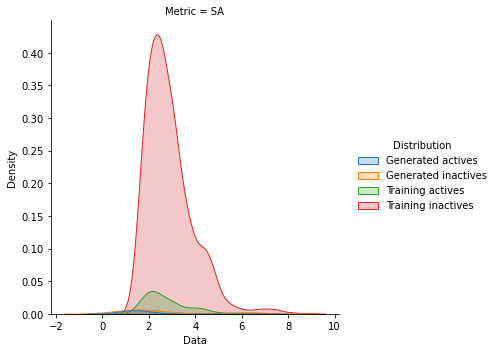

In [60]:
plot_distribution_basic(df_sa)

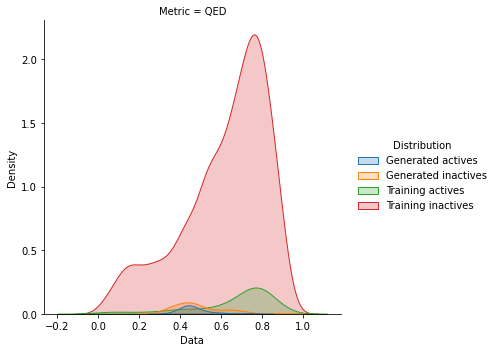

In [61]:
plot_distribution_basic(df_qed)

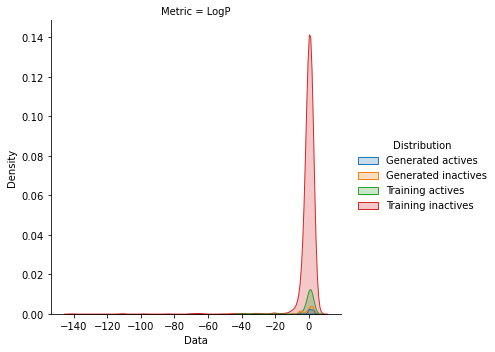

In [62]:
plot_distribution_basic(df_logp)

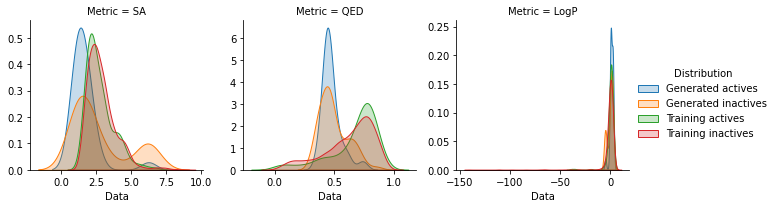

In [67]:
plot_distribution(df_metrics, save_path="./hmm_metrics.pdf", save=True)

## End of document